### Catalogs of mock detections 


In [1]:
# this command prevents Python from multithreading (useful especiallfy for clusters!)
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import pandas as pd
from tqdm import tqdm
#import GWFish.modules as gw
import h5py
import matplotlib.pyplot as plt
import corner
import matplotlib.lines as mlines
import multiprocessing as mpc
from itertools import repeat

from prior_distributions import *
from astropy.cosmology import Planck18 


In [2]:
mpc.cpu_count()

12

In [3]:
FinalStatement = 'WithPhysicalPriors'

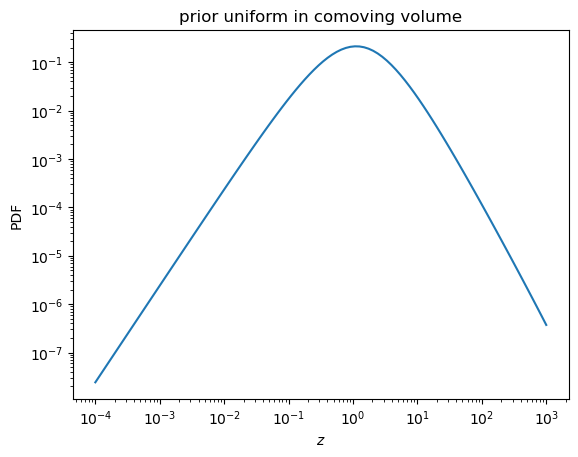

In [4]:
# Showing prior uniform in comoving volume

zz = np.geomspace(1e-4,1e3,100)
#print(zz)

def UniformInComovingVolume(z):
    # exaclty the same as Ulyana's
    dVc_dz = 4*np.pi*cosmo.differential_comoving_volume(z).value
    
    dl = cosmo.luminosity_distance(z).value
    
    dz_ddl = (dl / (1 + z) + (const.c.value / 1000) * (1 + z) / (cosmo.H(0).value * cosmo.efunc(z)))**(-1)


    dVc_ddl = dVc_dz*dz_ddl*(1/(1+z))

    return dVc_ddl


norm1 = np.trapz(UniformInComovingVolume(zz), zz)
plt.plot(zz, UniformInComovingVolume(zz)/norm1)


plt.xlabel(r'$z$')
plt.ylabel('PDF')
plt.yscale('log')
plt.xscale('log')
plt.title('prior uniform in comoving volume')
plt.show()



In [5]:
# here you define all prior ranges

# detector-frame primary mass
min_m1 = 0
max_m1 = 1e5

# detector-frame secondary mass
min_m2 = 0

# luminosity distance - limits are put in redshift
min_dl = 0
min_z = 1e-4
max_z = 1e3

# ra
min_ra = 0
max_ra = 2 * np.pi

# dec 
min_dec = -np.pi / 2.
max_dec = np.pi / 2.

# iota
min_iota = 0.
max_iota = np.pi

# phase 
min_phase = 0
max_phase = 2 * np.pi

# polarisation
min_psi = 0
max_psi = 2*np.pi

# coalescence time
min_time = 0
delta_time = 0.49




In [6]:
#print(z_at_value(Planck18.luminosity_distance, 2e5 * u.Mpc))
max_dl = np.array(Planck18.luminosity_distance(max_z)/ u.Mpc) #/1e7
print(max_dl)

13879748.634894684


In [7]:
def mass_prior(samples, min_value = min_m1):
	mask_m1 = samples['mass_1'] > min_value
	mask_m2 = samples['mass_2'] > min_value
	return np.logical_and(mask_m1, mask_m2)

def distance_prior(samples, min_value = min_dl):
	return samples['luminosity_distance'] > min_value

def ra_prior(samples, min_value = min_ra, max_value = max_ra):
	lower = samples['ra'] > min_value
	upper = samples['ra'] < max_value
	return np.logical_and(lower, upper)

def dec_prior_uniform(samples, min_value = min_dec, max_value = max_dec):
	lower = samples['dec'] > min_value
	upper = samples['dec'] < max_value
	return np.logical_and(lower, upper)

def iota_prior_uniform(samples, min_value = min_iota, max_value = max_iota):
	lower = samples['theta_jn'] > min_value
	upper = samples['theta_jn'] < max_value
	return np.logical_and(lower, upper)

def phase_prior(samples, min_value = min_phase, max_value = max_phase):
	lower = samples['phase'] > min_value
	upper = samples['phase'] < max_value
	return np.logical_and(lower, upper)

# I manually modify it to be [0, np.pi], what if psi has been generated between 0 and 2*
def psi_prior(samples, min_value = min_psi, max_value = max_psi):
	lower = samples['psi'] > min_value
	upper = samples['psi'] < max_value
	return np.logical_and(lower, upper)

def time_prior(samples, min_value = min_time):
	return samples['geocent_time'] > min_value

def uniform_priors(samples):
	filter_mass = mass_prior(samples)
	filter_dist = distance_prior(samples)
	filter_ra = ra_prior(samples)
	filter_dec = dec_prior_uniform(samples)
	mask1 = np.logical_and(np.logical_and(filter_mass, filter_dist), np.logical_and(filter_ra, filter_dec))
	filter_iota = iota_prior_uniform(samples)
	filter_phase = phase_prior(samples)
	filter_psi = psi_prior(samples)
	filter_time = time_prior(samples)
	mask2 = np.logical_and(np.logical_and(filter_iota, filter_phase), np.logical_and(filter_psi, filter_time))
	return np.logical_and(mask1, mask2)

In [8]:
def SamplingPosteriorWithPriors(mns_ev, cov_ev, n_sample, dis_par = False):
    """
    This function draws m1, m2, Dl from the multivariate gaussian distribution, 
    applying physical priors
    
    mns_data -> average values
    cov_data -> covariance matrix
    
    The passed arrays have been already masked for SNR and relative error cutoff
    """

    
    if n_sample == 1:
        # just resample the central value and using it as new max posteriors
        number_of_samples = 100
    elif n_sample == 1000:
        number_of_samples = 2000
    else:
        number_of_samples = int(n_sample*2)
        
    N = n_sample
    
    n = 0
    new_df = pd.DataFrame(columns = var_in_cov_matrix)
    n_in_while = 0
    max_in_while = int(5e3)
    while (n < number_of_samples) and (n_in_while < max_in_while):
        
        samples = np.random.multivariate_normal(mns_ev, np.squeeze(cov_ev), int(5e3), 
                                                check_valid = 'ignore')
        data_samples = pd.DataFrame(data = samples, columns = var_in_cov_matrix)

        mask_m1_m2 = data_samples['mass_1'] >= data_samples['mass_2']
        mask = np.logical_and(uniform_priors(data_samples),mask_m1_m2)
        #print(mask)
        len_selected_samples = len(np.argwhere(np.array(mask)))
        #print('number of selected samples', len_selected_samples)
        n = n + len_selected_samples
        # now I save these good samples
        new_df = pd.concat([new_df,data_samples.loc[mask]], ignore_index = True)
        n_in_while = n_in_while + 1

    if n_in_while >= max_in_while:
        print('While exited because too many trials. Total number of samples = ',n)
    #if n_sample == 1000:
    #    print('number of trials',n_in_while)
    
    # applying non-uniform priors but in the same ranges
    #print('total number of selected good samples', new_df.shape[0])
    priors_array = [
            uniform_pdf(new_df['mass_1'].to_numpy(), min_m1, max_m1),
            uniform_pdf(new_df['mass_2'].to_numpy(), min_m2, new_df['mass_1'].to_numpy()),
            uniform_in_differential_comoving_volume_pdf(
                new_df['luminosity_distance'].to_numpy(), 
                min_z, 
                max_z, 
                np.interp(new_df['luminosity_distance'].to_numpy(), 
                          dd, 
                          zz), norm_factor),
            uniform_in_cosine_pdf(new_df['dec'].to_numpy(), min_dec, max_dec),
            uniform_pdf(new_df['ra'].to_numpy(), min_ra, max_ra),
            uniform_in_sine_pdf(new_df['theta_jn'].to_numpy(), min_iota, max_iota),
            uniform_pdf(new_df['psi'].to_numpy(), min_psi, max_psi),
            uniform_pdf(new_df['geocent_time'].to_numpy(), mns_ev[ind_geocent_time] - delta_time, mns_ev[ind_geocent_time] + delta_time),
            uniform_pdf(new_df['phase'].to_numpy(), min_phase, max_phase)
                ] 
        
    new_df['prior']  = np.prod(priors_array, axis = 0)
    new_df['weights'] = new_df['prior']/new_df['prior'].sum()
    prob = new_df['weights'].to_numpy()
    index = np.random.choice(np.arange(new_df.shape[0]), size = N, replace = True, p = prob)
    sampled_df = new_df.iloc[index] # posterior samples

    #It return in orders: samples with applied priors, masked samples, and original samples from multivariate
    return sampled_df, new_df, data_samples

In [9]:
# path to folder where you store GWFish_results
path_local = ''
# error labels ---> in some catalogs redshift is not present
#lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
#     'theta_jn', 'psi', 'geocent_time', 'phase', 'redshift', 'err_mass_1',
#        'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
#            'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']


In [10]:
# available options
Pop_model = {'pessimistic':'pessimistic',
             'fiducial':'fiducial',
             'optimistic':'optimistic',
            'pop12':'pop12_10yr_v2'}

fisher_matrix_code = 'GWFish_results'


psds = ['ET_cryo']
psd = psds[0]

In [11]:
show_plot = True

# select model
model_here = Pop_model['pessimistic']

duration = '10'

cut_on_rel = 0.3

# write something here, you forgot!
#outer_model = 'Seed_8890' for taking different random seeds
outer_model = 'Pop.III'
#outer_model = 'Pop.I'
#outer_model = 'Pop.III'


#code_i = fisher_matrix_code+codes[outer_model]
#print(outer_model[:5])
print(outer_model, model_here)

if outer_model == 'Pop.III':
    model_here_abv = 'pop3_'
    codes = '/pop3'
    if model_here == 'fiducial':
        model_here_abv = model_here_abv+'fid'
        lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                         'theta_jn', 'psi', 'geocent_time', 'phase', 'redshift', 'err_mass_1',
                                'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
                                        'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']
    elif model_here == 'pessimistic':
        model_here_abv = model_here_abv+'pess'
        lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                 'theta_jn', 'psi', 'geocent_time', 'phase', 'redshift', 'err_mass_1',
                        'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
                                'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']
    elif model_here == 'optimistic':
        model_here_abv = model_here_abv+'opt'
        lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                         'theta_jn', 'psi', 'geocent_time', 'phase', 'redshift', 'err_mass_1',
                                'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
                                        'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']

elif outer_model == 'Pop.I':
    codes = '/pop12_10yr_v2'
    model_here_abv = 'pop12'
    lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                     'theta_jn', 'psi', 'geocent_time', 'phase', 'redshift', 'err_mass_1',
                            'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
                                    'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']
elif outer_model[:5] == 'Seed_':
    codes = '/pop3_randomized_seeds/'+outer_model
    model_here_abv = 'pop3_'
    if model_here == 'fiducial':
        model_here_abv = model_here_abv+'fid'
        # redshift removed
        lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                 'theta_jn', 'psi', 'geocent_time', 'phase', 'err_mass_1',
                        'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
                                'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']
    elif model_here == 'pessimistic':
        model_here_abv = model_here_abv+'pess'
        lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                 'theta_jn', 'psi', 'geocent_time', 'phase', 'redshift', 'err_mass_1',
                        'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
                                'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']
    elif model_here == 'optimistic':
        model_here_abv = model_here_abv+'opt'
        # redshift removed
        lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                 'theta_jn', 'psi', 'geocent_time', 'phase', 'err_mass_1',
                        'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
                                'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']
    elif model_here == 'pop12_10yr_v2':
        model_here_abv = 'pop12'
        # redshift removed
        lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                 'theta_jn', 'psi', 'geocent_time', 'phase', 'err_mass_1',
                        'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
                                'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']

code_i = fisher_matrix_code+codes


in_folder =  path_local+code_i
# load mean file
means_file = '%s/%s/%syr/%s/Errors_BBH_ET_%s_%syr.txt' %(str(in_folder), 
                                                               str(model_here), 
                                                               str(duration),
                                                               str(psd),
                                                               str(model_here_abv),
                                                               str(duration))
errors = pd.read_csv(means_file, names = lbs_errors, 
                     #header=0, 
                     delimiter = ' ', low_memory = False, skiprows = 1)
print('is detecting correct column names?')
print(errors.columns)
ind_nan, _ = np.where(errors.isna())
#print(errors.iloc[ind_nan])
print('detected NaN instances = ', ind_nan)

errors.dropna(inplace = True)


# load the covariance matrix 
cov_file = '%s/%s/%syr/%s/Inv_Fishers_BBH_ET_%s_%syr.npy' %(str(in_folder), 
                                                                  str(model_here), 
                                                                  str(duration), 
                                                                  str(psd),
                                                                  str(model_here_abv),
                                                                  str(duration))
cov_data = np.load(cov_file)
cov_data = np.delete(cov_data,ind_nan,axis = 0)


# I apply cut to keep a sample of well measured instances
SNRth = 12
thrs_m1 = cut_on_rel
thrs_m2 = cut_on_rel
thrs_L = cut_on_rel

# cut on SNR
SNRs = np.array(errors['network_SNR']) 
ind_snr = np.nonzero(SNRs>SNRth)[0]

dm1 = np.array(errors['err_mass_1'])
dm2 = np.array(errors['err_mass_2'])
dL = np.array(errors['err_luminosity_distance'])
# load features
m1 = np.array(errors['mass_1'])
m2 = np.array(errors['mass_2'])
L = np.array(errors['luminosity_distance'])
# here I apply the cuts on relative error
ind_m1 = np.nonzero(dm1/m1 < thrs_m1)[0]
ind_m2 = np.nonzero(dm2/m2 < thrs_m2)[0]
ind_L = np.nonzero(dL/L < thrs_L)[0]
ind_p = [ind_snr, ind_m1, ind_m2, ind_L]
ea = list(set.intersection(*map(set, ind_p)))

print('number of selected instances = ', len(ea))

if outer_model == 'Pop.III' and duration != '10':
    print('I take a subsample becasue they are too many')
    if cut_on_rel == 0.3:
        num_PopI_bal = 11_397 # this changes with different Seeds_
    elif cut_on_rel == 0.9:
        num_PopI_bal = 71_267
    else:
        raise ValueError('num of PopI for cut_on_rel not defined!')
        
    ea = np.random.choice(ea,#size = 15_000,
                          #size = 11_397, # exactly the same number of Pop.I-II
                          size = num_PopI_bal,
                          replace = False)


    print('number of selected instances after resampling = ', len(ea))

if len(ea) <= 1:
    raise ValueError('There are no systems with this option. Exiting function')

# these are the catalogs to insert the resampling function         
cov_data = cov_data[ea,:,:]
means_data = errors.iloc[ea]

Pop.III pessimistic
is detecting correct column names?
Index(['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra',
       'theta_jn', 'psi', 'geocent_time', 'phase', 'redshift', 'err_mass_1',
       'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra',
       'err_theta_jn', 'err_psi', 'err_geocent_time', 'err_phase',
       'err_sky_location'],
      dtype='object')
detected NaN instances =  []
number of selected instances =  22


In [12]:
# List the parameters as they appear in the covariance matrix
var_in_cov_matrix = ['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                    'theta_jn', 'psi', 'geocent_time', 'phase']
# index where you get the coalescence time
ind_geocent_time = 7 
#print('index geocent_time', ind_geocent_time)

# maximum and minimum redshift applied in priors
norm_factor = norm_factor_distance_prior(min_z, max_z)
#print('norm_factor', norm_factor)
#interpolator for luminosity distance
zz = np.linspace(min_z, max_z, 1000)
dd = Planck18.luminosity_distance(zz).value


# Take the corresponding columns to create the vector of mean values
mns = means_data[var_in_cov_matrix]

# Store the value of the total number of events and of the number of parameters considered for each event
ns = len(mns)
ns_check = len(cov_data[:,0,0])
if ns != ns_check:
    raise ValueError('issues with mean array and covariance array. Checked length')
npar = len(var_in_cov_matrix)


# check of the covariance matrix
checked_ind = []
counter = 1
print('checking covariance matrix')
for kk in tqdm(np.arange(ns), disable = False):
    # mns is a pandas dataframe
    mns_ev = np.array(mns.iloc[kk])
    # cov_ev is a numpy array
    cov_ev = cov_data[kk, :, :]
    # check if the covariance matrix is correct
    if abs(np.sqrt(cov_ev[0,0])-means_data['err_mass_1'].iloc[kk])/means_data['err_mass_1'].iloc[kk]>1e-3:
        print(counter, 'element at ', kk,
      'in errors array = ', mns_data['err_mass_1'].iloc[kk],
          'in the covariance matrix = ', np.sqrt(cov_ev[0,0]))
        counter += 1
    else:
        checked_ind.append(kk)
        #raise ValueError('issues with covariance array. Erros do not correspond')

### now I want to extract the new max posterior to train the classifier
new_mns = np.zeros((ns_check, npar))
kcount = 0

# loop over all the sources
for k in tqdm(range(ns_check), disable = False):
    # mns is a pandas dataframe
    mns_ev = np.array(mns.iloc[k])
    # cov_ev is a numpy array
    cov_ev = cov_data[k, :, :]


    # ignoring other outputs, taking one single sample to get new max posterior
    sampled_df, _ , _ = SamplingPosteriorWithPriors(mns_ev, cov_ev, 1, dis_par = False) 
    #print(sampled_df)
    
    new_mns[kcount,:] = np.array(sampled_df[var_in_cov_matrix])
    kcount += 1
    
# storing the new data
new_data_in = np.hstack([new_mns])
new_data =  pd.DataFrame(new_data_in,columns = var_in_cov_matrix)

checking covariance matrix


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 37.64it/s]


In [13]:
new_data

,mass_1,mass_2,luminosity_distance,dec,ra,theta_jn,psi,geocent_time,phase
0,57.936426,45.055037,5154.110448,-0.038179,5.105520,0.940023,3.051442,1.791405e+09,2.854438
1,88.830129,15.349858,8011.050629,-0.492956,1.149224,2.288826,4.914072,1.635532e+09,3.726731
2,118.718744,61.408926,11243.471473,-0.443884,4.591921,0.893350,4.891052,1.879480e+09,1.534274
3,84.304091,68.628013,12536.024023,-0.511226,0.599903,2.623574,4.308108,1.828108e+09,5.397635
4,116.056522,31.687245,19007.153836,0.103886,2.657993,0.968482,3.063681,1.724461e+09,4.566020
5,113.516387,33.823511,14885.805249,-1.148613,6.239273,2.259765,4.279124,1.872655e+09,3.791806
6,157.206501,61.968133,27215.266853,-0.367345,5.417564,0.690155,1.338889,1.760141e+09,4.480756
7,142.426964,83.864686,21595.579966,0.652706,0.124165,2.368754,2.292932,1.827043e+09,6.071144
8,179.851406,94.039735,23909.279241,-0.002112,0.218370,0.459268,0.056226,1.633889e+09,2.272506
9,176.379055,67.741759,27262.962896,0.651562,3.287227,0.316469,4.101443,1.737325e+09,0.503121


In [14]:
means_data_save = errors.iloc[ea]
means_data_save.index = np.arange(len(means_data_save))

In [15]:
means_data_save

,network_SNR,mass_1,mass_2,luminosity_distance,dec,ra,theta_jn,psi,geocent_time,phase,...,err_mass_1,err_mass_2,err_luminosity_distance,err_dec,err_ra,err_theta_jn,err_psi,err_geocent_time,err_phase,err_sky_location
0,90.549577,56.705696,46.040269,5493.962576,0.107699,4.987329,0.868388,2.484023,1.791405e+09,3.810116,...,0.553700,0.448428,906.066403,0.267893,0.103219,0.113119,0.904107,0.002488,1.491633,0.053511
1,34.490873,88.961873,15.326028,8875.456887,-0.542610,1.126046,2.416332,5.256802,1.635532e+09,4.273275,...,0.159288,0.026387,698.214504,0.109177,0.063662,0.090965,1.352133,0.000942,2.505647,0.013792
2,85.092177,118.738834,61.391838,12520.880112,-0.446278,4.600991,0.769327,4.938569,1.879480e+09,1.466854,...,0.504336,0.281388,2166.291847,0.710257,0.374052,0.051630,0.220573,0.002897,1.151446,0.415363
3,44.748319,80.834266,71.855275,12520.880112,-0.512264,0.572996,2.722917,4.166208,1.828108e+09,5.030490,...,4.299598,3.849600,2592.185746,0.012011,0.030553,0.287369,22.987952,0.000456,45.869554,0.000977
4,28.817828,116.098195,31.716318,13274.234425,0.055229,2.241605,1.011229,4.107725,1.724461e+09,2.889415,...,0.449603,0.130674,2931.557931,0.116975,0.262169,0.165923,0.726995,0.003132,1.138944,0.088416
5,24.475007,112.677738,34.145953,21951.684687,-1.243647,6.080544,2.574237,3.647279,1.872655e+09,2.142854,...,0.727745,0.232328,2510.628434,0.059886,0.432408,0.137558,3.880349,0.001092,8.716099,0.022880
6,20.612549,153.750092,63.535599,23591.087608,-0.251471,5.203182,1.001046,2.419171,1.760141e+09,3.148834,...,1.519304,0.731590,4373.610340,0.138281,0.147988,0.253173,1.131564,0.001724,1.780080,0.043191
7,27.682431,140.934223,84.863787,23591.087608,0.663547,0.162981,2.457269,2.187415,1.827043e+09,5.895505,...,3.090188,2.027677,4273.136524,0.046618,0.103695,0.182262,3.079536,0.001135,6.201194,0.006978
8,36.149335,177.484420,95.538112,25245.808533,0.041473,0.232560,0.434295,0.992254,1.633889e+09,0.567507,...,2.630036,1.636227,3343.472725,0.030236,0.061098,0.121559,10.035462,0.001378,19.999199,0.004606
9,36.608485,174.887207,68.441902,30291.770122,0.636686,3.206371,0.339593,2.883025,1.737325e+09,2.918685,...,1.818661,0.835155,2517.423089,0.124282,0.111639,0.091475,14.784968,0.001301,29.783209,0.029390


In [16]:
new_data

,mass_1,mass_2,luminosity_distance,dec,ra,theta_jn,psi,geocent_time,phase
0,57.936426,45.055037,5154.110448,-0.038179,5.105520,0.940023,3.051442,1.791405e+09,2.854438
1,88.830129,15.349858,8011.050629,-0.492956,1.149224,2.288826,4.914072,1.635532e+09,3.726731
2,118.718744,61.408926,11243.471473,-0.443884,4.591921,0.893350,4.891052,1.879480e+09,1.534274
3,84.304091,68.628013,12536.024023,-0.511226,0.599903,2.623574,4.308108,1.828108e+09,5.397635
4,116.056522,31.687245,19007.153836,0.103886,2.657993,0.968482,3.063681,1.724461e+09,4.566020
5,113.516387,33.823511,14885.805249,-1.148613,6.239273,2.259765,4.279124,1.872655e+09,3.791806
6,157.206501,61.968133,27215.266853,-0.367345,5.417564,0.690155,1.338889,1.760141e+09,4.480756
7,142.426964,83.864686,21595.579966,0.652706,0.124165,2.368754,2.292932,1.827043e+09,6.071144
8,179.851406,94.039735,23909.279241,-0.002112,0.218370,0.459268,0.056226,1.633889e+09,2.272506
9,176.379055,67.741759,27262.962896,0.651562,3.287227,0.316469,4.101443,1.737325e+09,0.503121


In [17]:
# now I need to save this catalog but also to keep the injected values
result = pd.concat([means_data_save, new_data], axis = 1 #,ignore_index=True
                  )

In [18]:
result.iloc[3]

network_SNR                4.474832e+01
mass_1                     8.083427e+01
mass_2                     7.185528e+01
luminosity_distance        1.252088e+04
dec                       -5.122640e-01
ra                         5.729960e-01
theta_jn                   2.722917e+00
psi                        4.166208e+00
geocent_time               1.828108e+09
phase                      5.030490e+00
redshift                   1.643290e+00
err_mass_1                 4.299598e+00
err_mass_2                 3.849600e+00
err_luminosity_distance    2.592186e+03
err_dec                    1.201100e-02
err_ra                     3.055300e-02
err_theta_jn               2.873690e-01
err_psi                    2.298795e+01
err_geocent_time           4.560000e-04
err_phase                  4.586955e+01
err_sky_location           9.770000e-04
mass_1                     8.430409e+01
mass_2                     6.862801e+01
luminosity_distance        1.253602e+04
dec                       -5.112255e-01


In [19]:
ind = np.array(result['err_mass_1'])/np.array(result['mass_1'])[:,0]<cut_on_rel
print(len(np.nonzero(ind)[0]))
ind = np.array(result['err_luminosity_distance'])/np.array(result['luminosity_distance'])[:,0]<cut_on_rel
print(len(np.nonzero(ind)[0]))
ind = np.array(result['network_SNR'])>7
print(len(np.nonzero(ind)[0]))

22
22
22


In [20]:
result.to_csv('measured_values_v1/meas_cat_'+outer_model+'_'+model_here +'_'+str(cut_on_rel)+'_'+duration+'yr_'+FinalStatement+'.dat',header = 
              [         'network_SNR', 
                        'mass_1', 
                        'mass_2', 
                        'luminosity_distance', 
                        'dec', 
                        'ra', 
                        'theta_jn', 
                        'psi', 
                        'geocent_time', 
                        'phase', 
                        'redshift', # this is a problem!!!! you might remove it for some catalogs
                        'err_mass_1',
                        'err_mass_2', 
                        'err_luminosity_distance', 
                        'err_dec', 
                        'err_ra', 
                        'err_theta_jn',
                        'err_psi', 
                        'err_geocent_time', 
                        'err_phase', 
                        'err_sky_location',
                        'r_mass_1', 
                        'r_mass_2', 
                        'r_luminosity_distance', 
                        'r_dec', 
                        'r_ra', 
                        'r_theta_jn', 
                        'r_psi', 
                        'r_geocent_time', 
                        'r_phase'])

In [21]:
# check if the saved file is good
errors['err_mass_1'].iloc[ea]



0       0.553700
2       0.159288
6       0.504336
7       4.299598
8       0.449603
14      0.727745
16      1.519304
17      3.090188
19      2.630036
24      1.818661
25      7.859437
29      1.654352
40      2.664237
46      4.145031
47      2.607542
58     37.743261
69     32.300645
74     11.265845
88     74.414221
94     38.979054
121     5.830672
122    67.462698
Name: err_mass_1, dtype: float64

In [22]:
result['err_mass_1']

0      0.553700
1      0.159288
2      0.504336
3      4.299598
4      0.449603
5      0.727745
6      1.519304
7      3.090188
8      2.630036
9      1.818661
10     7.859437
11     1.654352
12     2.664237
13     4.145031
14     2.607542
15    37.743261
16    32.300645
17    11.265845
18    74.414221
19    38.979054
20     5.830672
21    67.462698
Name: err_mass_1, dtype: float64

In [23]:
# parameters of the corner plot
font_value = 10

# corner plot arguments 
CORNER_KWARGS = dict(
    smooth = 0.7, # smooths out contours. 
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = font_value), # font size for labels
    #show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = font_value), # font size for title
    plot_density = True,
    #title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    #max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    #title_fmt=".3f",
    #axes_scale='log',
    #denity = True
    )

  0%|                                                                                                                                                                                          | 0/22 [00:00<?, ?it/s]

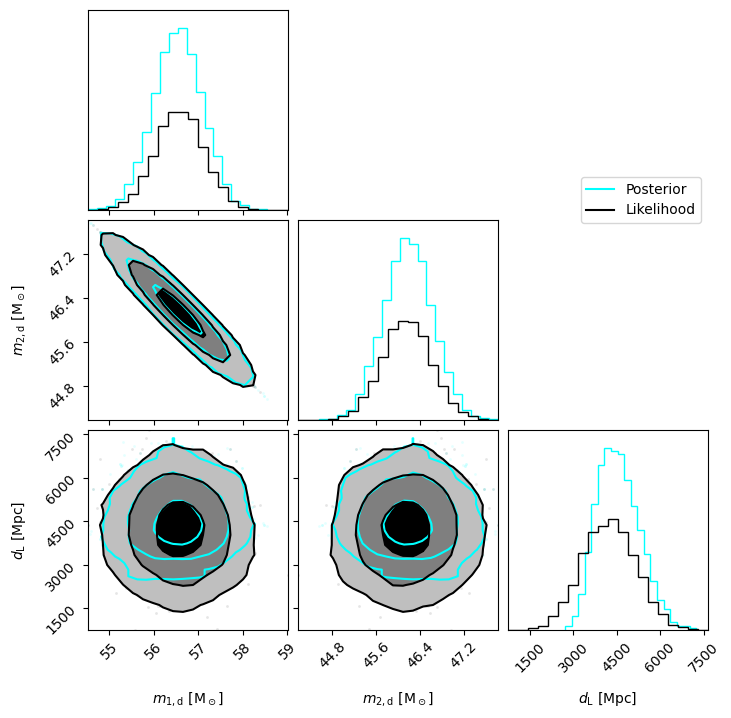

  5%|████████                                                                                                                                                                          | 1/22 [00:00<00:16,  1.31it/s]

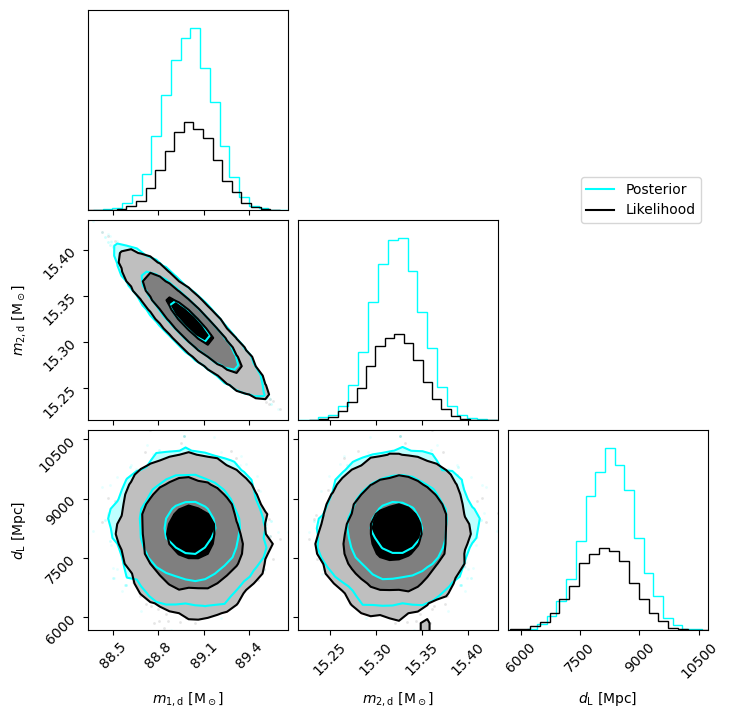

  9%|████████████████▏                                                                                                                                                                 | 2/22 [00:01<00:13,  1.47it/s]

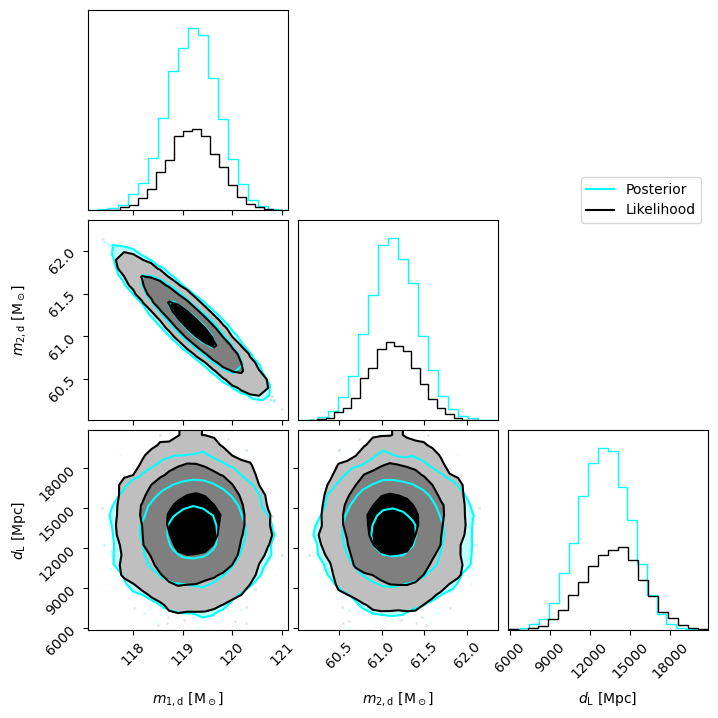

 14%|████████████████████████▎                                                                                                                                                         | 3/22 [00:02<00:13,  1.44it/s]

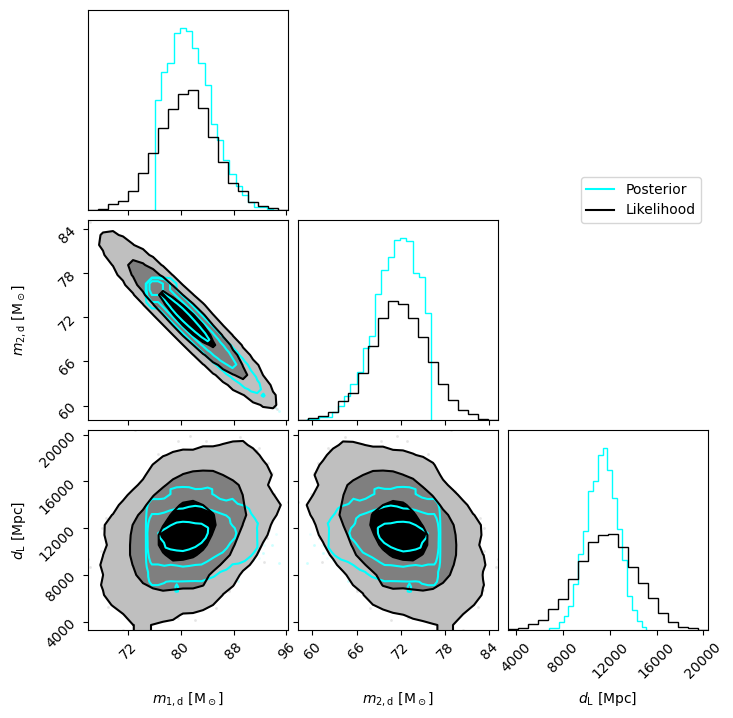

 18%|████████████████████████████████▎                                                                                                                                                 | 4/22 [00:02<00:13,  1.31it/s]

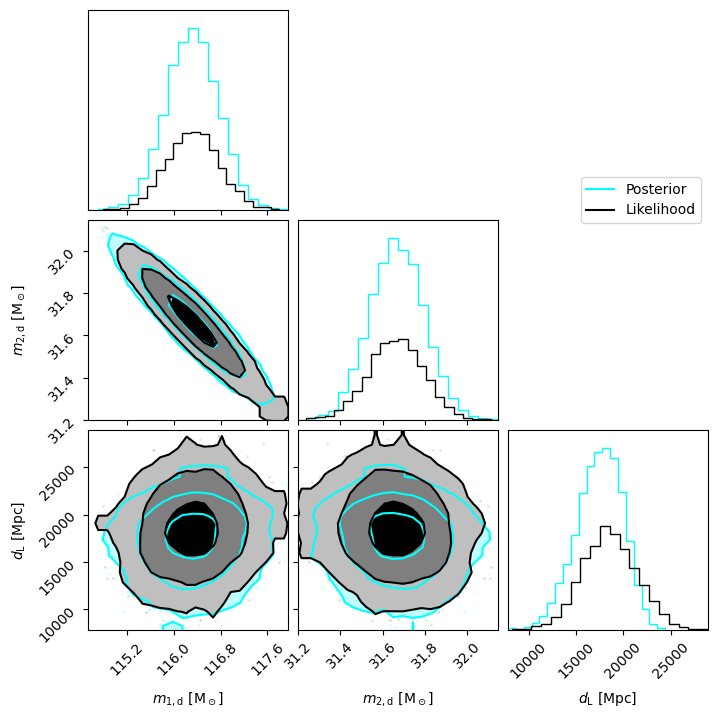

 23%|████████████████████████████████████████▍                                                                                                                                         | 5/22 [00:03<00:12,  1.38it/s]

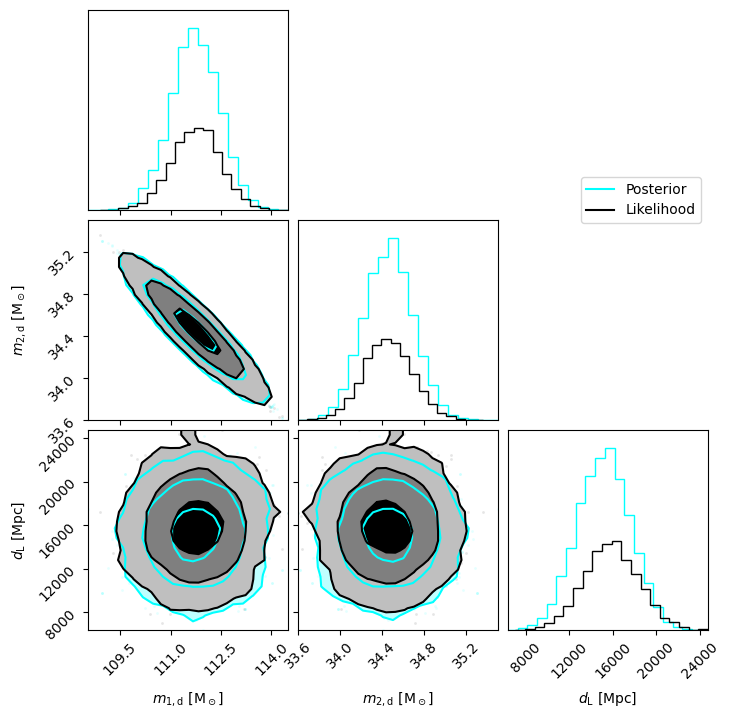

 27%|████████████████████████████████████████████████▌                                                                                                                                 | 6/22 [00:04<00:11,  1.39it/s]

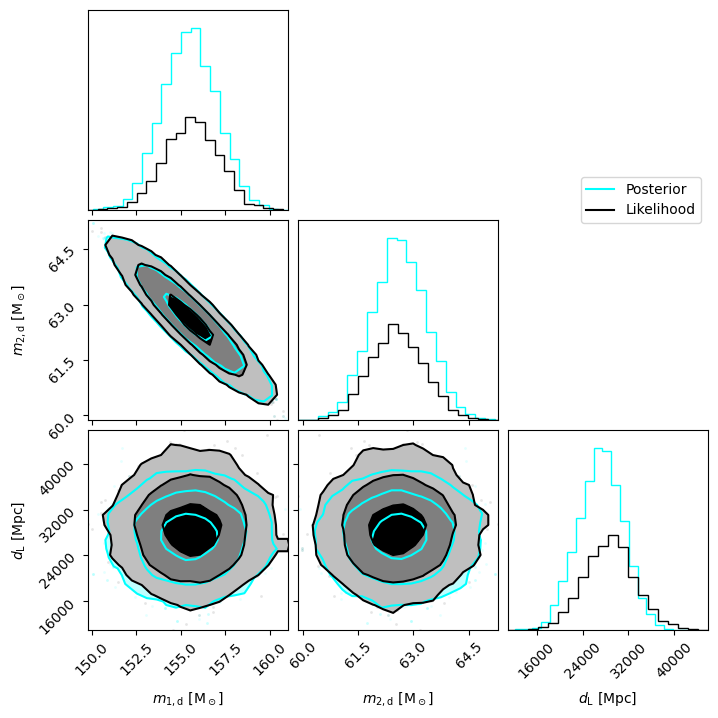

 32%|████████████████████████████████████████████████████████▋                                                                                                                         | 7/22 [00:04<00:10,  1.42it/s]

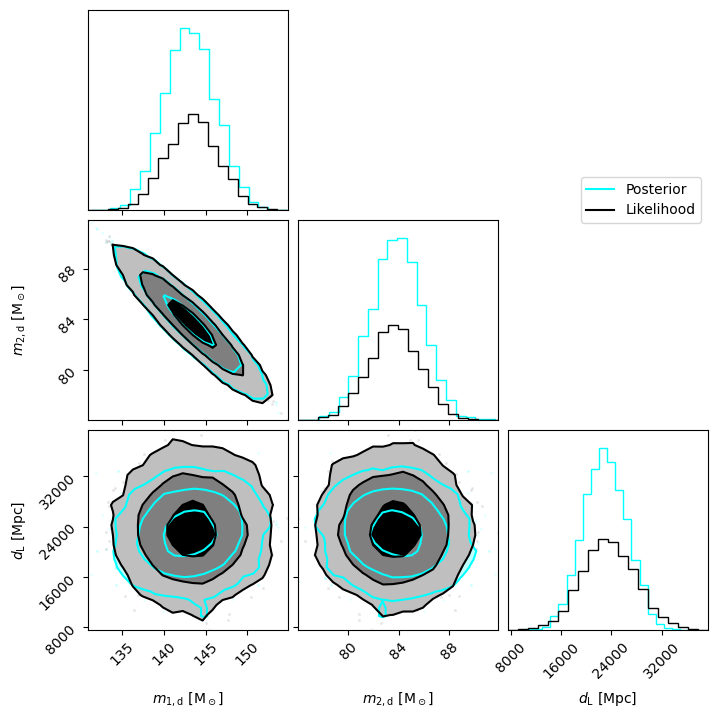

 36%|████████████████████████████████████████████████████████████████▋                                                                                                                 | 8/22 [00:05<00:09,  1.41it/s]

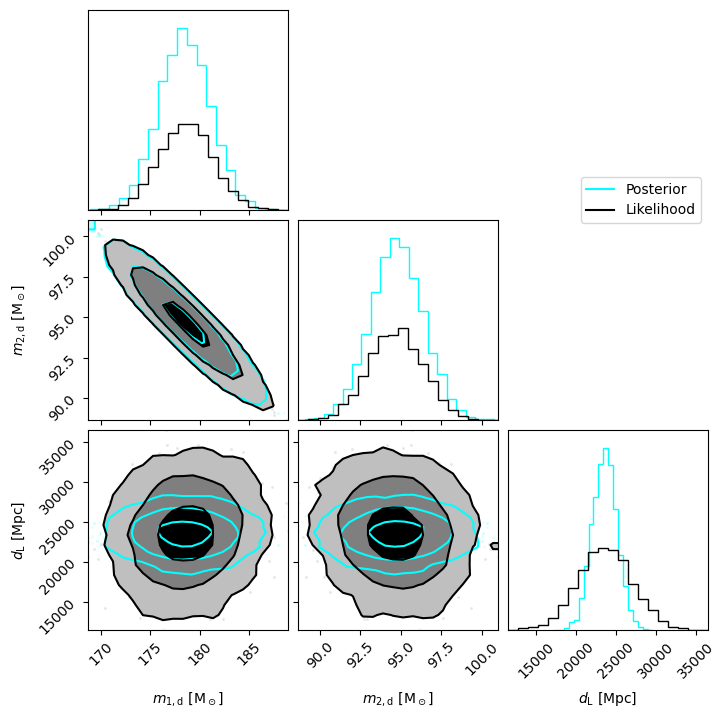

 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9/22 [00:06<00:09,  1.34it/s]

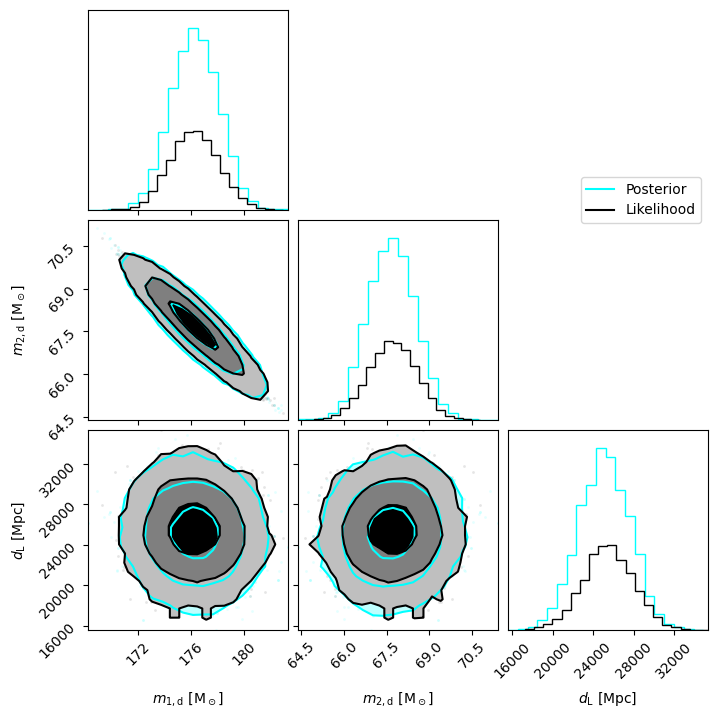

 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 10/22 [00:07<00:08,  1.34it/s]

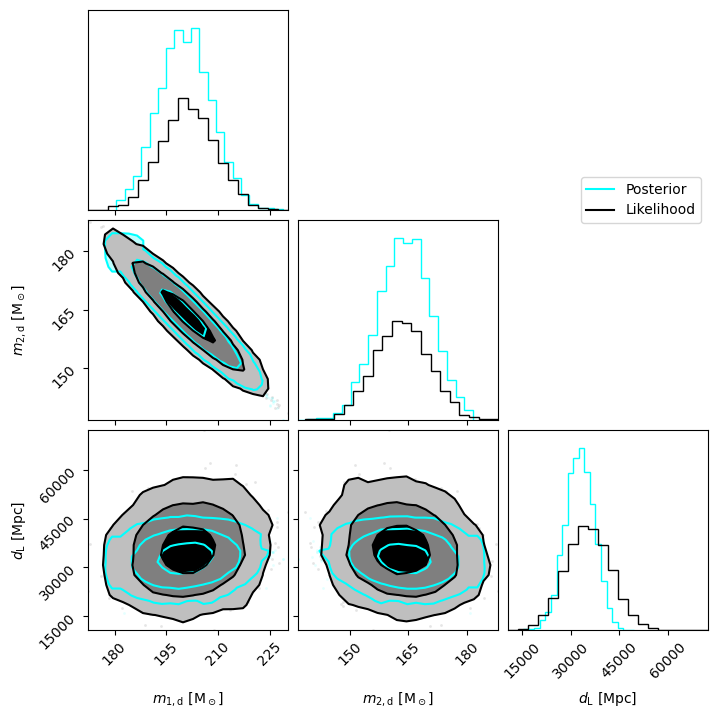

 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 11/22 [00:07<00:08,  1.37it/s]

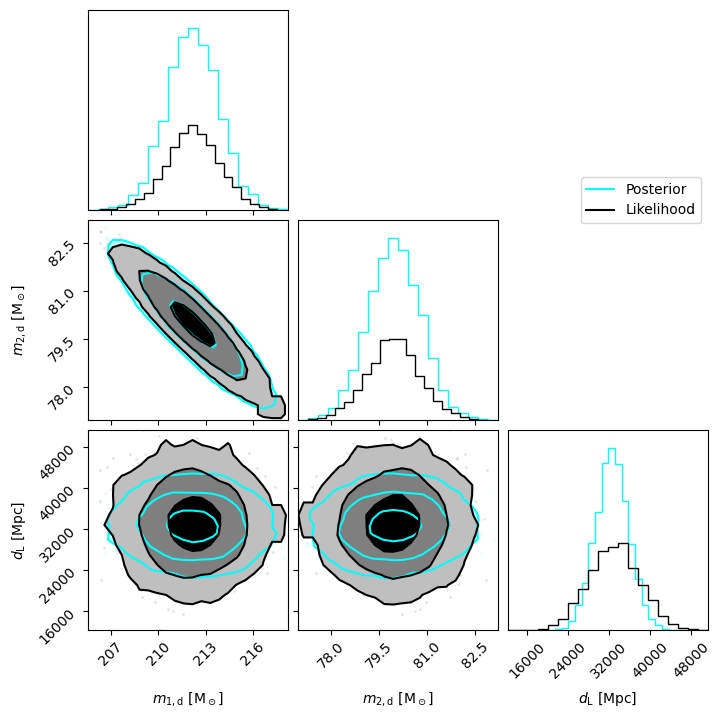

 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/22 [00:08<00:07,  1.42it/s]

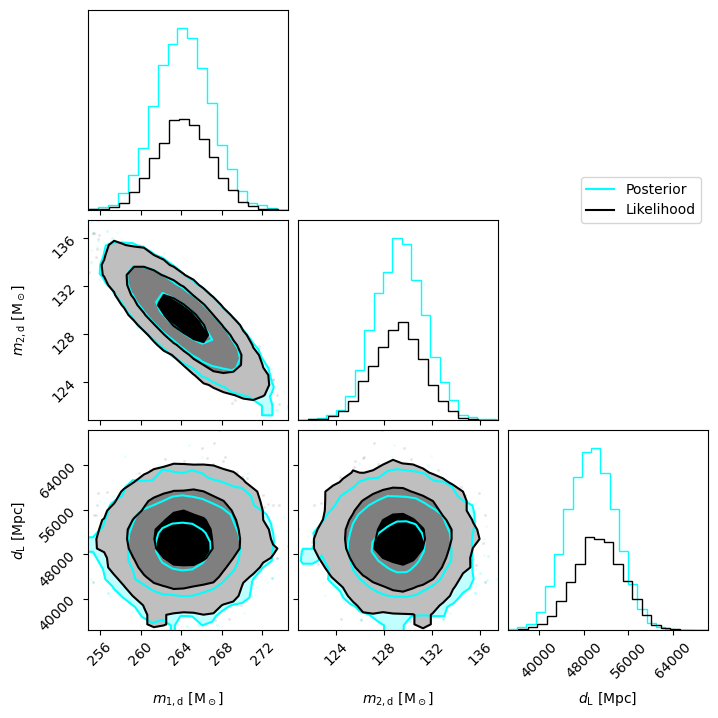

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 13/22 [00:09<00:07,  1.24it/s]

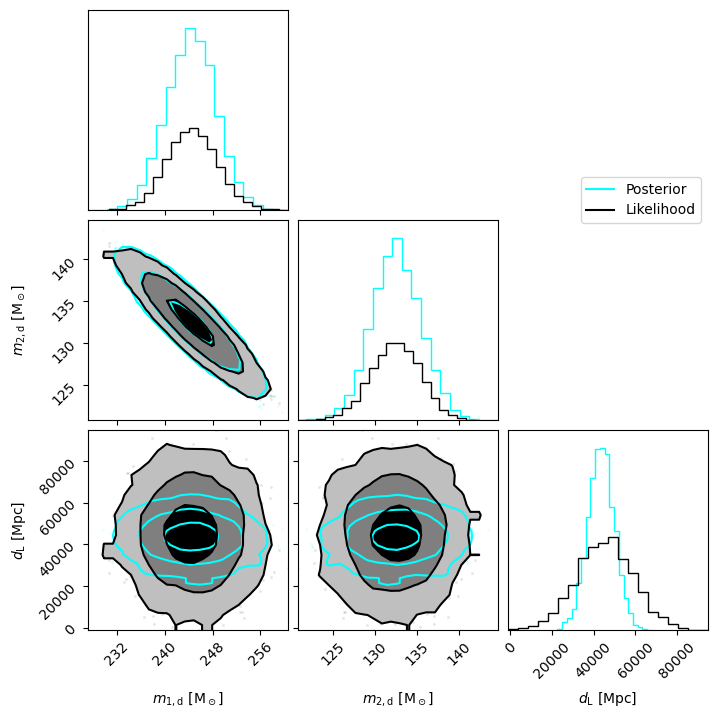

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 14/22 [00:10<00:06,  1.18it/s]

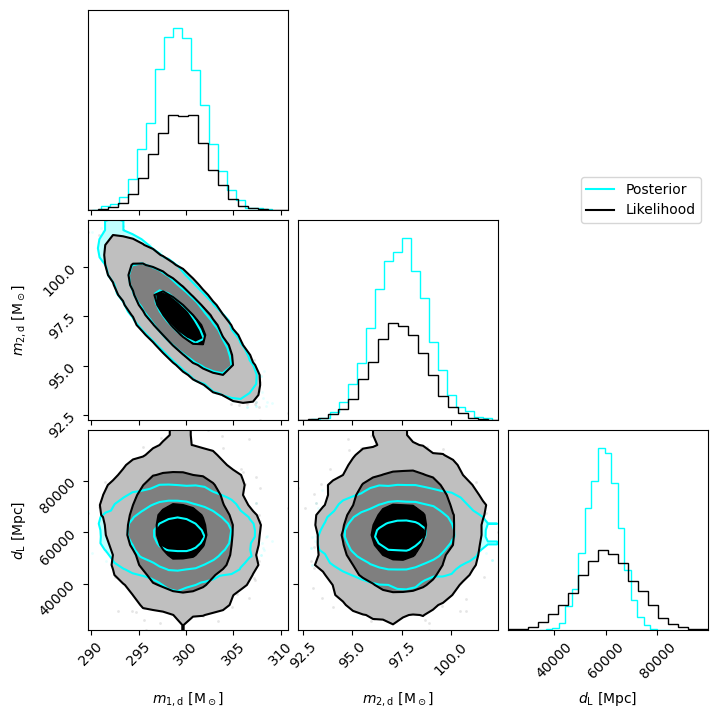

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 15/22 [00:12<00:07,  1.01s/it]

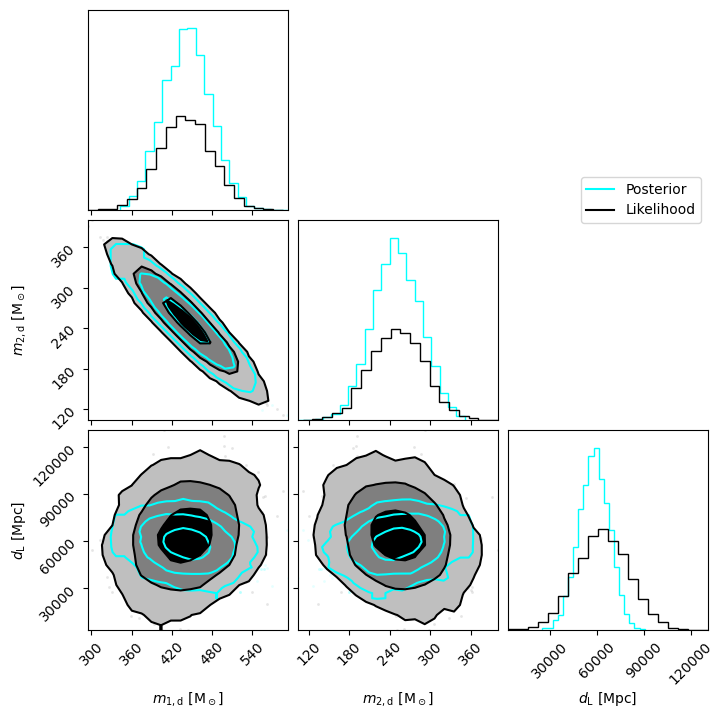

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 16/22 [00:13<00:06,  1.05s/it]

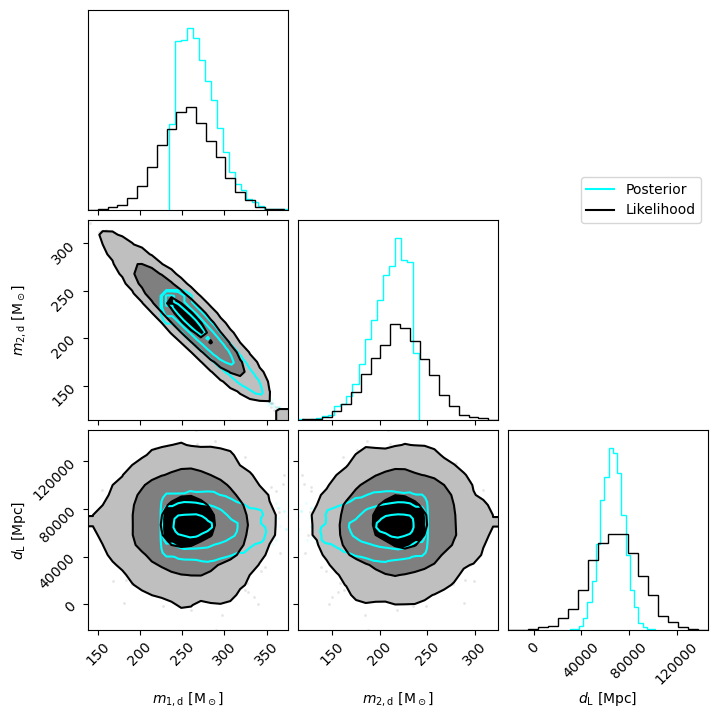

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 17/22 [00:25<00:22,  4.57s/it]

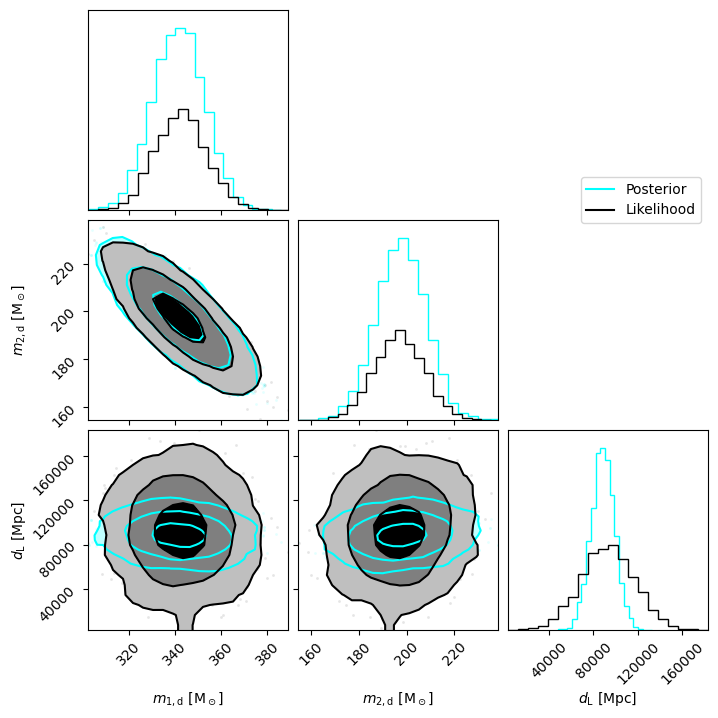

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18/22 [00:27<00:14,  3.75s/it]

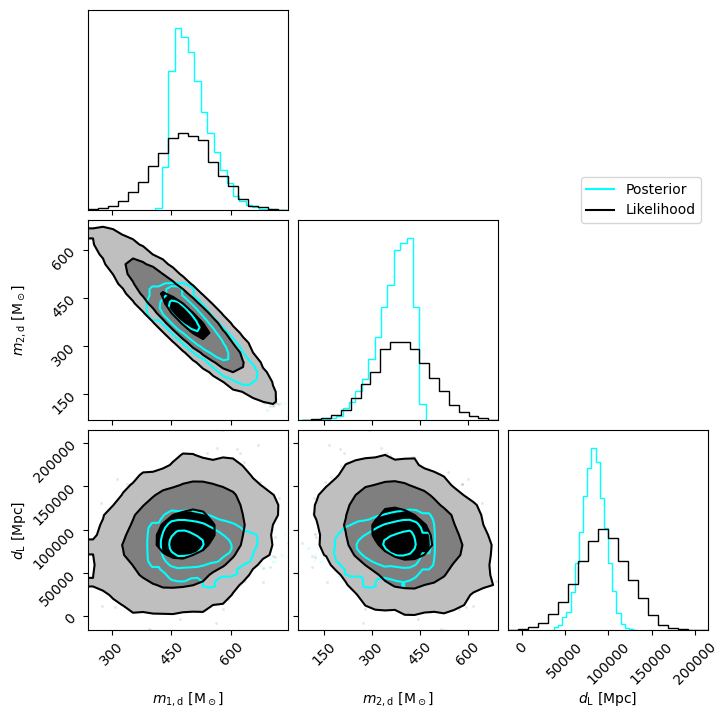

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 19/22 [00:33<00:13,  4.34s/it]

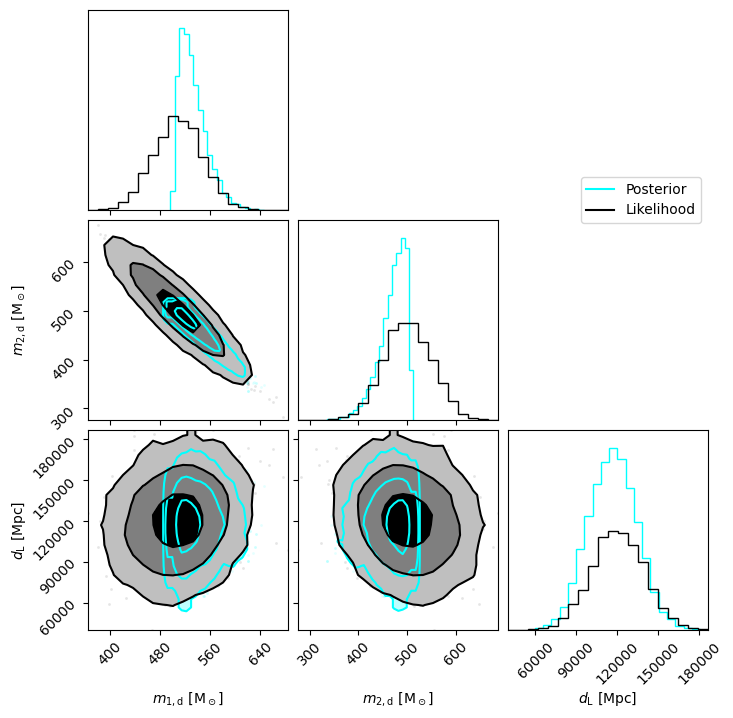

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 20/22 [00:34<00:06,  3.44s/it]

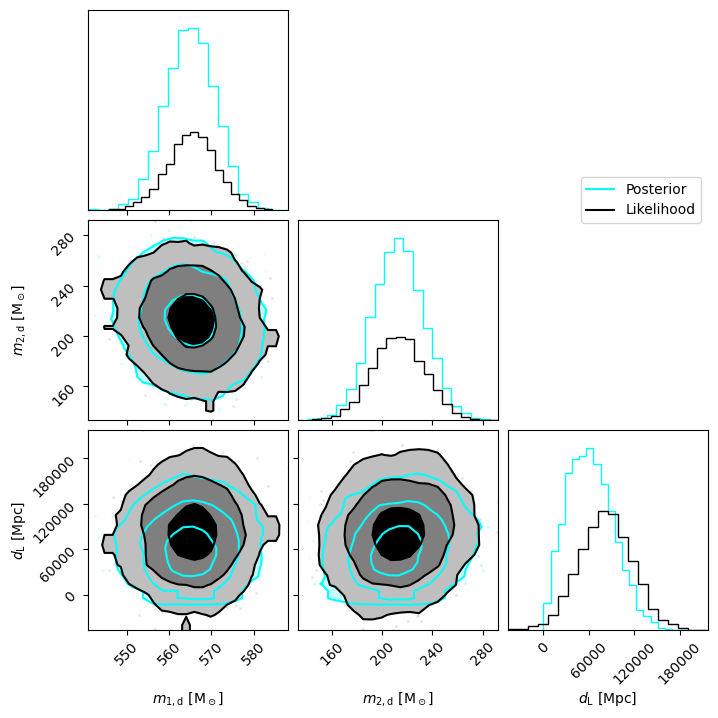

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 21/22 [00:36<00:02,  2.78s/it]

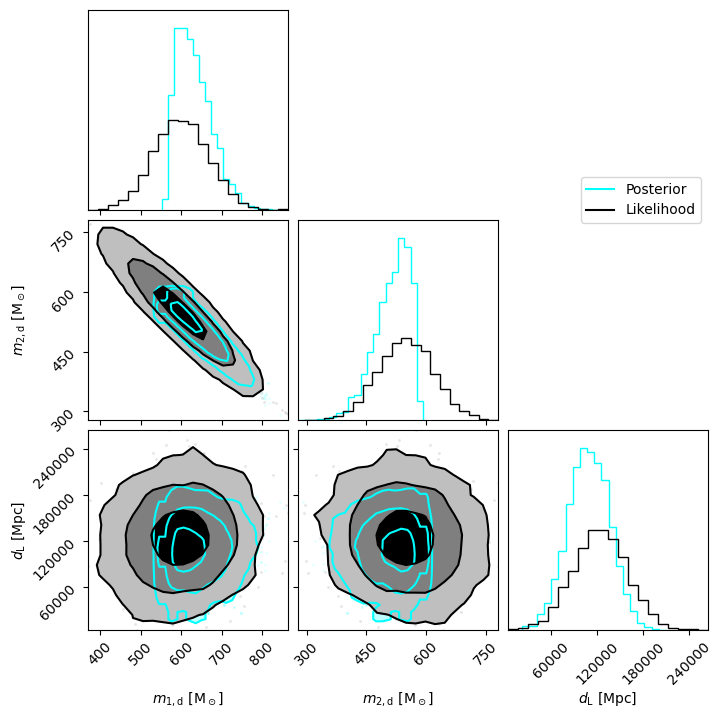

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:37<00:00,  1.71s/it]


In [24]:
# test catalogs

folder_test = 'test_catalogs_v1/'

# number of sample for each source
num_of_sam = int(10000)

# number of sources 
subsample = len(ea)

# array to store the new sample of mock posteriors for each source
#new_sam = np.zeros((subsample,3,num_of_sam)) #--> this is only m1,m2 e dL
new_sam = np.zeros((subsample,9,num_of_sam)) #--> this is are all the parameters



new_mns_ev_array = np.zeros((ns_check, npar))
kcount = 0

# saving posterior samples of mock detections 
# you might need to close the hdf5 file before opening it
#f.close()
f = h5py.File(folder_test+'test_cat_'+outer_model+'_'+model_here +'_'+str(cut_on_rel)+'_'+duration+'yr_'+FinalStatement+'.h5', "w")



# loop over the sources
for k in tqdm(range(ns_check), disable = False):
    # mns is a pandas dataframe
    mns_ev = np.array(mns.iloc[k])
    # cov_ev is a numpy array
    cov_ev = cov_data[k, :, :]

    # I am taking again a new max posteriors to ensure to not overfit Pop. I-II
    sampled_df, _, _ = SamplingPosteriorWithPriors(mns_ev, cov_ev, 1, dis_par = False)

    new_mns_ev = sampled_df[var_in_cov_matrix]
    #print(np.squeeze(new_mns_ev.to_numpy()))
    #print(new_mns_ev.to_numpy())

    new_mns_ev_array[kcount,:] = np.array(new_mns_ev)
    
    
    #print(new_mns_ev)
    # taking num_of_sam samples of the posterios centered on a new max posterior
    sampled_df, Masked, FromGWFish,  = SamplingPosteriorWithPriors(np.squeeze(new_mns_ev.to_numpy()), cov_ev, num_of_sam, dis_par = False)
    
    # showing a corner plot for each source and only for the pessimistic model
    if show_plot == True and model_here == 'pessimistic' and duration == '10' and cut_on_rel == 0.3:
        #print(sampled_df[var_in_cov_matrix], FromGWFish, Masked[var_in_cov_matrix])

        ## with priors
        #nsamples = sampled_df[var_in_cov_matrix].shape[0]
        ##print(nsamples)
        var_in_cov_matrix_plot = ['mass_1', 'mass_2', 'luminosity_distance']
        var_in_cov_matrix_labels = [r'$m_{1,\mathrm{d}}$ [M$_\odot$]', r'$m_{2,\mathrm{d}}$ [M$_\odot$]', r'$d_{\mathrm{L}}$ [Mpc]']
        figure_1 = corner.corner(sampled_df[var_in_cov_matrix_plot], 
                          bins = 20,labels = var_in_cov_matrix_labels, 
                                 color = 'cyan', #truths = new_mns_ev,
                               **CORNER_KWARGS)#,weights=np.ones(nsamples)/nsamples)
       
        ## No priors
        #nsamples = FromGWFish[var_in_cov_matrix].shape[0]
        ##print(nsamples)
        corner.corner(FromGWFish[var_in_cov_matrix_plot], 
                          bins = 20,labels = var_in_cov_matrix_labels,
                      color = 'black', #truths = new_mns_ev,
                    fig = figure_1, **CORNER_KWARGS)#,weights=np.ones(nsamples)/nsamples)

        ## only masked 
        #nsamples = Masked[var_in_cov_matrix].shape[0]
        ##print(nsamples)
        #corner.corner(Masked[var_in_cov_matrix], 
        #                  bins = 20,labels = var_in_cov_matrix, 
        #              color = 'green', #truths = new_mns_ev,
        #             density = True, fig = figure_1, **CORNER_KWARGS)#,weights=np.ones(nsamples)/nsamples)
        
        lines = [mlines.Line2D([], [], color='cyan', label='Posterior'),
                 mlines.Line2D([], [], color='black', label='Likelihood'),
                 #mlines.Line2D([], [], color='green', label='Masked')
                ]
        
        plt.legend(handles=lines, 
                    bbox_to_anchor=(0., 2.0, 1., .0), loc=4, fontsize = font_value)

        plt.savefig(folder_test+'/CornerPlotsToInspectSampling/CornerPlot_'+str(kcount)+'_talk_v2.pdf', format = 'pdf')
        plt.show()
    

    # storing just masses and luminosity distance to test the classifiers
    #new_sam[k,:,:] = np.transpose(sampled_df[['mass_1','mass_2','luminosity_distance']])
    new_sam[k,:,:] = np.transpose(sampled_df[['mass_1','mass_2','luminosity_distance','dec','ra','theta_jn','psi', 'geocent_time', 'phase']])

    
    #for h in range(subsample):
    grp = f.create_group("instance_"+str(k))
    grp.create_dataset("samples", data = np.array(new_sam[k,:,:]))
    
    kcount += 1

# storing the new data
new_data_in = np.hstack([new_mns_ev_array])
result_to_med =  pd.DataFrame(new_data_in,columns = var_in_cov_matrix)

f.close()

In [25]:
result_to_med.to_csv(folder_test+'/median_cat_'+outer_model+'_'+model_here +'_'+str(cut_on_rel)+'_'+duration+'yr_'+FinalStatement+'.dat',
                     header = var_in_cov_matrix)

In [26]:
result_to_med

,mass_1,mass_2,luminosity_distance,dec,ra,theta_jn,psi,geocent_time,phase
0,56.563887,46.165054,4206.755176,-0.347652,5.063127,0.789607,3.952175,1.791405e+09,1.324445
1,89.013816,15.321816,8105.524498,-0.416496,1.264419,2.321936,3.274498,1.635532e+09,0.563648
2,119.193509,61.143201,13761.945914,-0.536806,4.565429,0.708338,4.957973,1.879480e+09,1.414733
3,80.843127,71.867759,11736.761723,-0.522838,0.589359,2.503290,4.662566,1.828108e+09,6.041468
4,116.319941,31.664523,18539.135043,0.152199,2.770843,0.987841,2.632998,1.724461e+09,5.163620
5,111.756769,34.450725,15831.771774,-1.055997,6.015794,2.373653,3.277963,1.872655e+09,1.561488
6,155.585734,62.576230,28703.551858,-0.245204,5.277843,0.616255,2.044078,1.760141e+09,3.640749
7,143.375387,83.659045,23614.791446,0.640948,0.116001,2.440091,1.871553,1.827043e+09,5.058620
8,178.598167,94.677767,23766.224892,0.032833,0.267693,0.477614,1.134352,1.633889e+09,0.311720
9,176.244090,67.693155,25538.700434,0.581226,3.335367,0.494471,2.776391,1.737325e+09,3.251673


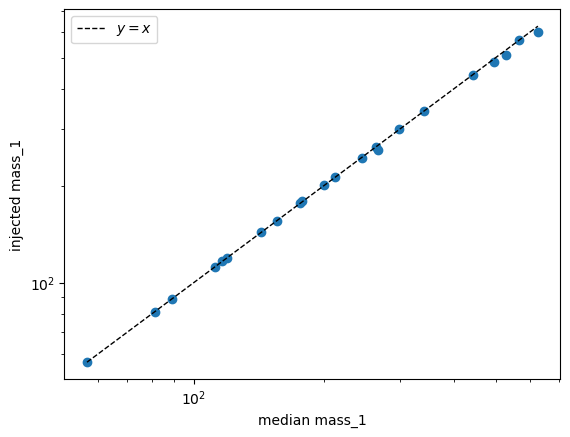

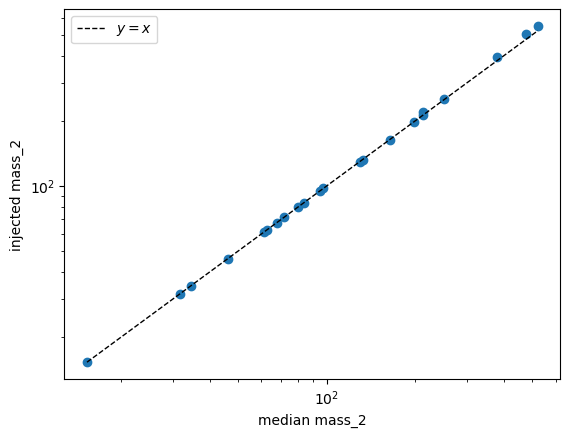

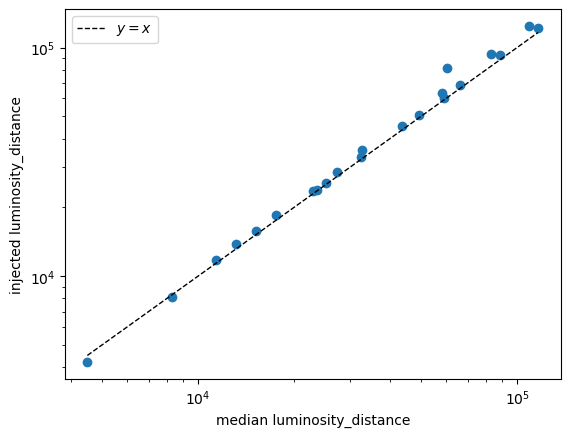

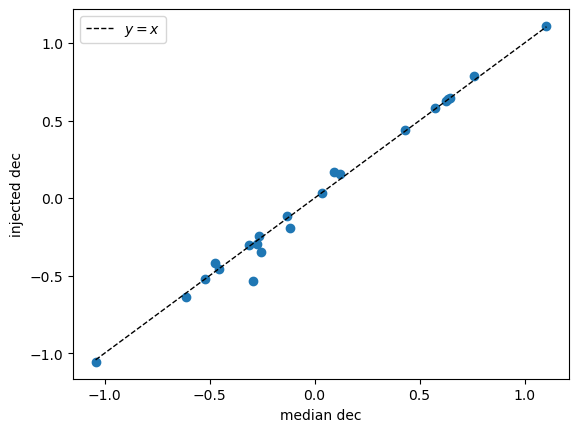

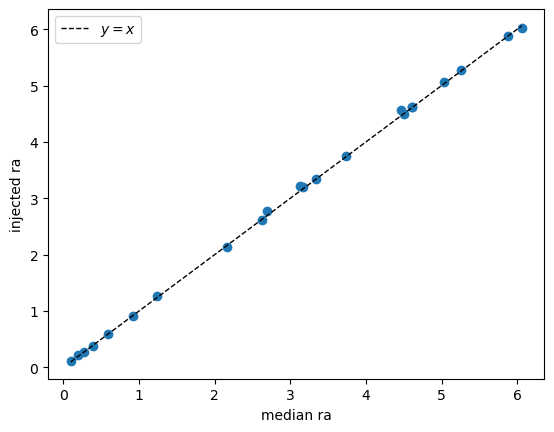

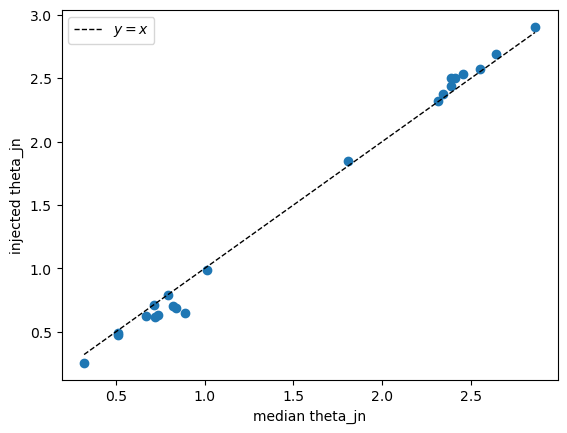

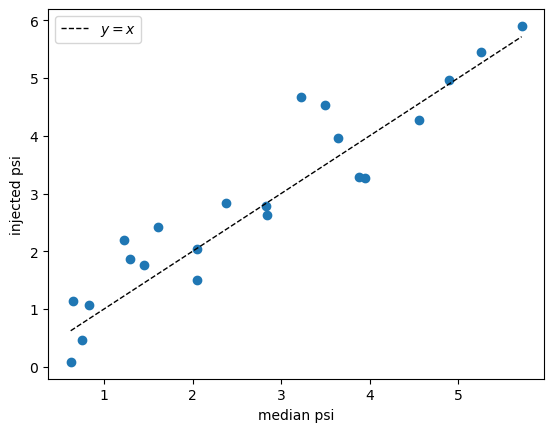

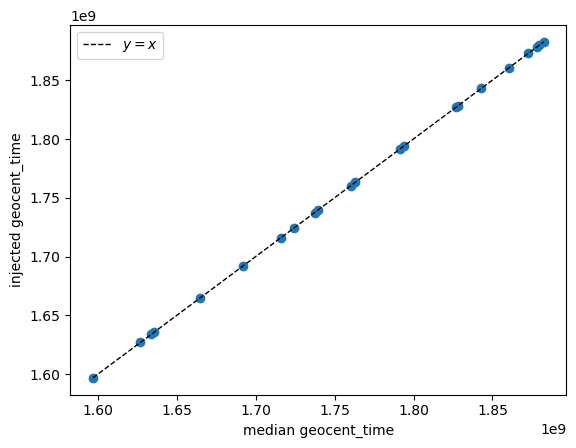

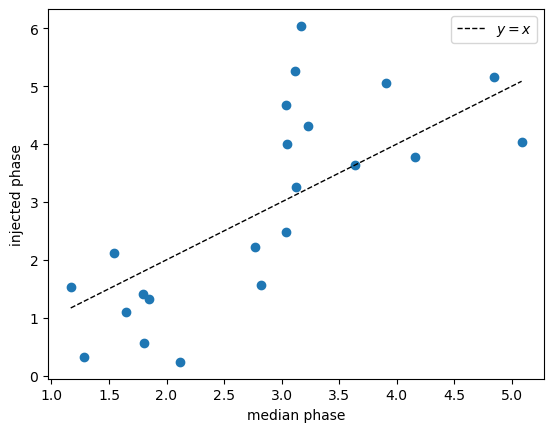

In [27]:
#params_scatter = ['mass_1','mass_2','luminosity_distance']
params_scatter = ['mass_1','mass_2','luminosity_distance','dec','ra','theta_jn','psi', 'geocent_time', 'phase']

if show_plot == True:
    for p in range(len(params_scatter)):
        medians_arr = []
        central_arr = []
        for i in range(subsample):
    

            medians = np.median(new_sam[i,:,:], axis = 1)
            medians_arr.append(medians[p])
            #print(medians)
            #print(new_data[['mass_1','mass_2','lumirosity_distance']].iloc[i])
            central = result_to_med[params_scatter].iloc[i]
            central_arr.append(np.array(central[p]))
            
    
            
        plt.scatter(medians_arr, central_arr)

        
        plt.xlabel('median '+params_scatter[p])
        plt.ylabel('injected '+params_scatter[p])
        if params_scatter[p] == 'mass_1' or params_scatter[p] == 'mass_2' or params_scatter[p] == 'luminosity_distance':
            plt.xscale('log')
            plt.yscale('log')
        
        arr_to_check = np.linspace(np.min(medians_arr),
                                   np.max(medians_arr),100) #np.linspace(min(medians_arr),max(medians_arr),100)
        plt.plot(arr_to_check,arr_to_check,lw = 1, ls = '--', label = r'$y=x$', color = 'black')

        plt.legend()
        plt.show()
        